In [189]:
import numpy as np
import math
#from scipy.stats import poisson
#import matplotlib.pyplot as plt

In [190]:
#import seaborn as sns
#sns.set(style="whitegrid")

## Forward Simulation

Parameters:

In [191]:
alpha = 0.9
beta = 0.2
lambda_p = [1,5]
gamma = 0.1

Big gamma matrix:

In [192]:
big_gamma = np.array([
    [1- gamma, 0, gamma], 
    [0, 1-gamma, gamma], 
    [beta/2, beta/2, 1- beta]
    ])

Simulation function

In [193]:
def sim(n,T):
    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}
    
    Zs = [np.random.binomial(1, p = probs[c], size = n) for c in C]
    Z_flat = np.array(Zs).flat

    Xs = np.reshape([np.random.poisson(1+4*z) for z in Z_flat], newshape=(T, n))

    return [C, Zs, Xs]


## Visualizing

In [6]:
C, Z, X = sim(10,100)

In [7]:
color = {0:'red', 1:'green', 2: 'blue'}
C_color = [color[c] for c in C]
C_color

['blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red']

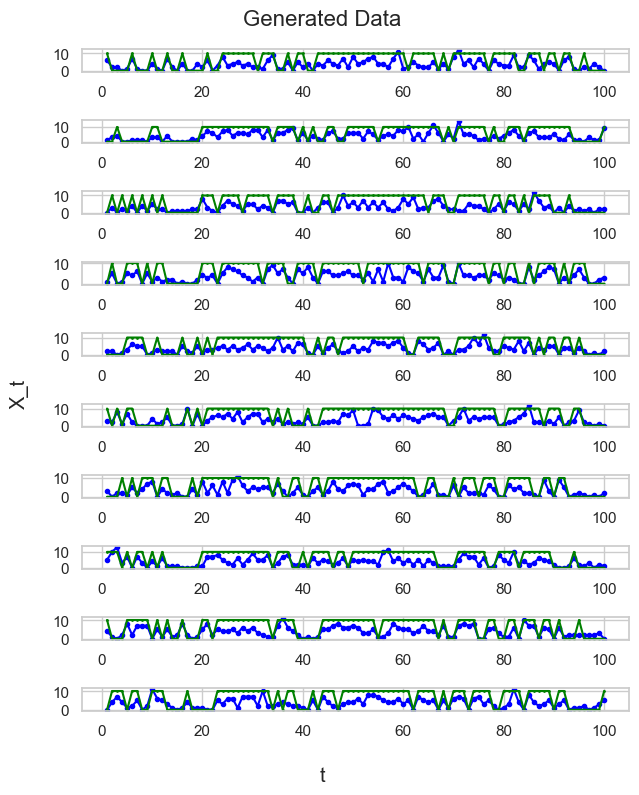

In [8]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))

for i in range(10):
    y_plot = X[:, i] 
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='blue')
    y_plot_z = [Z[0][i]*10]
    for j in range(1,100):
        y_plot_z.append(Z[j][i]*10)
    axs[i].plot(x_plot, y_plot_z, marker='o', markersize=1, color = 'green')
    #axs[i].text(1.05, 0.5, f'{i + 1}', fontsize=12, rotation=270)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()


In [9]:
X_avg = [None]*100

for i in range(100):
    X_avg[i] = np.mean(X[i,:])

Text(0.5, 1.0, 'Average')

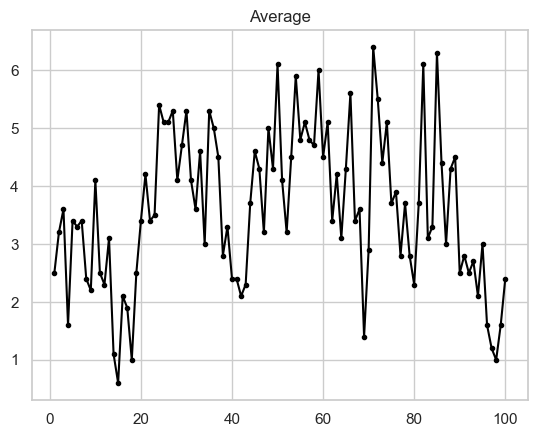

In [10]:
plt.plot(x_plot, X_avg, marker='o', markersize=3, color='black')
plt.title('Average')

## Multinomial logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [92]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C, Z, X = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C[i], Z[i], X[i] = sim(n2,T)


In [13]:
X_reg = X.reshape((1000, n2*T))
lr = LogisticRegression(max_iter=5000)
lr.fit(X_reg, C[:,49])

LogisticRegression(max_iter=5000)

Prediction accuracy

In [14]:
np.random.seed(80)
n1 = 1000

C_test, Z_test, X_test = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1, T, n2))

for i in range(n1):
    C_test[i], Z_test[i], X_test[i] = sim(10,100)

X_reg_test = X_test.reshape((1000, 100*10))

np.mean(lr.predict(X_reg_test) == C_test[:,49])


0.668

In [15]:
lr.coef_

array([[ 0.03707576,  0.07556136,  0.02679373, ...,  0.01847613,
        -0.02778083,  0.03911787],
       [-0.06965838, -0.17429022,  0.01776721, ..., -0.01074624,
        -0.03011102, -0.04705927],
       [ 0.03258263,  0.09872886, -0.04456094, ..., -0.00772989,
         0.05789184,  0.0079414 ]])

In [16]:
print(np.mean(lr.coef_[0]), np.mean(lr.coef_[1]), np.mean(lr.coef_[2]))

-0.000813642936020122 -9.472616592041926e-05 0.0009083691019386659


Predict from only certain X's

In [17]:
new_x_reg = X[:,48:51,:]
new_x_reg = new_x_reg.reshape((1000, 10*3))

In [18]:
lr2 = LogisticRegression(max_iter=5000)
lr2.fit(new_x_reg, C[:,49])

LogisticRegression(max_iter=5000)

Accuracy

In [19]:
X_reg_test = X_test[:,48:51,:]
X_reg_test = X_reg_test.reshape((1000, 10*3))

np.mean(lr2.predict(X_reg_test) == C_test[:,49])

0.882

# Inference

In [7]:
#n = 3
#T = 5
#p_zc = np.array([[alpha, 1-alpha],[1-alpha,alpha], [0.5,0.5]]) #(C_i,Z_ij)
#
#p_zc

array([[0.9, 0.1],
       [0.1, 0.9],
       [0.5, 0.5]])

Clique potentials

In [22]:
#psi_l_1 = np.array([big_gamma[0]*0, big_gamma[1]*0, big_gamma[2]*1]) #(C_1,C_2)
#psi_l_i = big_gamma #(C_i,C_i+1) # i = 1,..,T-1
#psi_m_i = np.zeros(shape = [3,n+1]) #(C_i, #Z_ij = 1) i = 1,..,T-1, j=1,..,n 
#for c_val in range(3):
#    psi_m_i[c_val,:] = [(p_zc[c_val,0]**(n-sum_z_ij))*(p_zc[c_val,1]**(sum_z_ij)) for sum_z_ij in range(n+1)]

In [23]:
#def psi_n_i(xs):
#    def func(zs):
#        k = sum(zs)
#        lambdas = reduce(lambda x, y: x * y, [lambda_p[z]**x for z,x in zip(zs, xs)])
#        factorials = reduce(lambda x,y: x*y, [math.factorial(x) for x in xs])
#        exponentials = np.exp( - ((len(zs) - k) * lambda_p[0] + k * lambda_p[1]))
#        return exponentials * lambdas / factorials
#    return func
#

Data

In [39]:
#C, Z, X = sim(n,T)

Messages: Upwards pass

In [40]:
# Sending messag from N_i clique (consists of X's and Z's) to M_i (consists of Z's and C_i) clique 
#delta_ni_mi_list = [None]*T
#for i in range(T):
#    delta_ni_mi_list[i] = psi_n_i(X[i,:]) # function of Zs

In [41]:
# Sending messag from M_i clique (consists of Z's and C_i) to L_i clique (C_i and C_{i+1}) 
#delta_mi_li_list = np.empty(shape = (T,3)) #(t,C_t) t=1,...,T
#for t in range(T):
#    for c_val in range(3):
#        delta_mi_li_list[t, c_val] = sum([psi_m_i[c_val,sum(zs)] * delta_ni_mi_list[t](zs) for zs in list(product([0, 1], repeat=n))])

In [42]:
# Sending messag from L_i clique (consists of C_i and C_i+1) to L_i+1 clique (C_i+1 and C_{i+2}) 
#delta_li_i1_list = np.empty(shape = (T-1,3)) #(t, C_t+1) t=1,...,T-1
#
#for t in range(T-1):
#    for c_i_ in range(3):
#        if t == 0:
#            delta_li_i1_list[t,c_i_] = sum([psi_l_1[c_i,c_i_] * delta_mi_li_list[0,c_i] for c_i in [0,1,2]])
#        delta_li_i1_list[t, c_i_] = sum([psi_l_i[c_i,c_i_] * delta_mi_li_list[t,c_i] for c_i in [0,1,2]])

## Downward pass
Clique belief of clique L_{T-1}

In [134]:
#beta_l_T_minus_1 = np.empty(shape = (3,3)) 
#beta_l_T_minus_1[0,:] = psi_l_i[0,:]*delta_mi_li_list[T-1,:]*delta_li_i1_list[T-2,0]*delta_mi_li_list[T-2,0]
#beta_l_T_minus_1[1,:] = psi_l_i[1,:]*delta_mi_li_list[T-1,:]*delta_li_i1_list[T-2,1]*delta_mi_li_list[T-2,1]
#beta_l_T_minus_1[2,:] = psi_l_i[2,:]*delta_mi_li_list[T-1,:]*delta_li_i1_list[T-2,2]*delta_mi_li_list[T-2,2]
##Normalizing
#beta_l_T_minus_1 /= sum(sum(beta_l_T_minus_1))
#beta_l_T_minus_1

array([[3.46183122e-04, 0.00000000e+00, 1.77186831e-03],
       [0.00000000e+00, 6.97602461e-01, 1.54231058e-02],
       [4.73952423e-04, 1.09722695e-01, 1.74659734e-01]])

In [144]:
#beliefs_l_t = np.empty(shape = (T-1,3,3)) # (t,C_t,C_{t+1})
#delta_li1_i_list = np.empty(shape = (T-1,3)) #(t, C_t+1) t=1,...,T-1
#for t in range(T-2,0,-1):
#    if t == T-2:
#        beliefs_l_t[t,0,:] = psi_l_i[0,:]*delta_mi_li_list[t+1,:]*delta_li_i1_list[t,0]*delta_mi_li_list[t,0]
#        beliefs_l_t[t,1,:] = psi_l_i[1,:]*delta_mi_li_list[t+1,:]*delta_li_i1_list[t,1]*delta_mi_li_list[t,1]
#        beliefs_l_t[t,2,:] = psi_l_i[2,:]*delta_mi_li_list[t+1,:]*delta_li_i1_list[t,2]*delta_mi_li_list[t,2]
#        beliefs_l_t[t,:,:] /= sum(sum(beliefs_l_t[t,:,:]))
#    for c_i in range(3):                                                                            # compute delta_{L_t+1} to L_t
#        delta_li1_i_list[t-1,c_i] =  sum([beliefs_l_t[t,c_i,c] / delta_li_i1_list[t,c_i] for c in [0,1,2]])
#    beliefs_l_t[t-1,0,:] = psi_l_i[0,:]*delta_mi_li_list[t-1,:]*delta_li_i1_list[t-2,0]*delta_li1_i_list[t-1,0]
#    beliefs_l_t[t-1,1,:] = psi_l_i[1,:]*delta_mi_li_list[t-1,:]*delta_li_i1_list[t-2,1]*delta_li1_i_list[t-1,1]
#    beliefs_l_t[t-1,2,:] = psi_l_i[2,:]*delta_mi_li_list[t-1,:]*delta_li_i1_list[t-2,2]*delta_li1_i_list[t-1,2]
#    beliefs_l_t[t-1,:,:] /= sum(sum(beliefs_l_t[t,:,:]))
#
#beliefs_l_t

array([[[1.48854343e-09, 0.00000000e+00, 1.47011315e-09],
        [0.00000000e+00, 5.72025892e-04, 6.34020187e-05],
        [8.52045651e-07, 7.59214892e-06, 6.05877205e-05]],

       [[1.28342658e-08, 0.00000000e+00, 3.07606613e-08],
        [0.00000000e+00, 1.81140144e-02, 5.10844092e-04],
        [2.53655861e-06, 2.15573748e-04, 4.37725691e-04]],

       [[5.43542240e-10, 0.00000000e+00, 2.18732195e-09],
        [0.00000000e+00, 2.79231181e-04, 7.29434018e-06],
        [2.37189616e-08, 3.65386910e-06, 6.87238658e-06]],

       [[3.46183122e-04, 0.00000000e+00, 1.77186831e-03],
        [0.00000000e+00, 6.97602461e-01, 1.54231058e-02],
        [4.73952423e-04, 1.09722695e-01, 1.74659734e-01]]])

In [159]:
#delta_li_mi_list = np.empty(shape = (T,3)) #(t,C_t) t=1,...,T
#for t in range(T-1):
#    for c_val in range(3):
#        delta_li_mi_list[t, c_val] = sum([beliefs_l_t[t,c_val, c_1]/delta_mi_li_list[t,c_val]  for c_1 in [0,1,2]])
#delta_li_mi_list[T-1, c_val] = sum([beliefs_l_t[T-2,c_val, c_1]/delta_mi_li_list[T-1,c_val]  for c_1 in [0,1,2]]) 
#
#delta_li_mi_list

array([[1.87136016e-05, 4.51052666e-01, 4.91225587e-02],
       [1.33234389e-03, 6.69764905e+00, 9.29198458e-01],
       [2.07002836e-03, 1.40988014e+00, 2.20803365e-01],
       [6.06599131e+00, 6.09241676e+02, 1.91755288e+02],
       [1.03245115e-05, 2.39018343e-03, 5.98946980e+02]])

In [ ]:
#beliefs_m_t = np.empty(shape = (T,3,n+1)) # (t,C_t,k_i)
#for t in range(T-1,-1,-1):
#    beliefs_m_t = psi_m_i[2,:]*delta_li_mi_list[t-1,:]*delta_ni_mi_list[t-2,2]


In [145]:
#psi_m_i * delta_li_mi * delta_ni_mi_list[t] #(C_i, #Z_ij = 1)

array([[0.729, 0.081, 0.009, 0.001],
       [0.001, 0.009, 0.081, 0.729],
       [0.125, 0.125, 0.125, 0.125]])

# Inference part two

We use the clique graph $\{C_{t}, C_{t+1}\} \text{––} \{C_t, Z_{tj}\} \text{––} \{Z_{tj}, X_{tj}\}$. First we initialize three arrays with the **initial factors**

We start by defining the clique potentials

In [194]:
psi_l_i = big_gamma                                                         # (C_t, C_{t+1})
psi_l_1 = np.array([big_gamma[0]*0, big_gamma[1]*0, big_gamma[2]*1])        # (C_1,C_2)
psi_m = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5,0.5]])           # (C_t, Z_{ti})
def psi_n(x):                                                               # (Z_{ti}, X_{ti})
    def func(z):
        return np.exp(-lambda_p[z])*lambda_p[z]**x / math.factorial(x)
    return func

Data

In [195]:
n=10
T=100
C, Z, X = sim(n,T)

We then implement the computation of the four messages: $\delta_{n \to m}$, $\delta_{m \to l}$ and $\delta_{{l_{t-1}} \to l_{t}}$.

In [196]:
# Sending messag from N_ti clique (consists of X_{ti} and Z_{ti}) to M_ti (consists of Z_{ti} and C_t) clique 
delta_ni_mi_list = [[None]*n]*T
for i in range(T):
    for j in range(n):
        delta_ni_mi_list[i][j] = psi_n(X[i,j]) # function of Z_{ti}

In [197]:
# Sending message from M_i clique (consists of Z_ti and C_t) to L_i clique (C_t and C_{t+1}) 
delta_mi_li_list = np.empty(shape = (T,n,3)) #(t,i,C_t) t=1,...,T
for t in range(T):
    for i in range(n):
        for c_val in range(3):
            delta_mi_li_list[t, i, c_val] = sum([psi_m[c_val,z] * 
                                                 delta_ni_mi_list[t][i](z) for z in [0, 1]])  # Summing out Z_{ti}, leaving a factor of C_t 

In [198]:
# Sending messag from L_t clique (consists of C_t and C_{t+1}) to L_t+1 clique (C_t+1 and C_{t+2}) 
delta_li_i1_list = np.empty(shape = (T-2,3)) #(t,C_{t+1}) t=1,...,T-1

delta_li_i1_list[0,:] = [sum([psi_l_1[c_i,c_i_] * np.prod(delta_mi_li_list[1,:,:], axis = 0)[c_i] 
                              for c_i in [0,1,2]]) for c_i_ in [0,1,2]] # Summing out C_{t}, leaving a factor of C_{t+1} 

delta_li_i1_list[0,:] /= sum(delta_li_i1_list[0,:])                     # Normalizing

for t in range(1,T-2):
    for c_i_ in range(3):
        delta_li_i1_list[t, c_i_] = sum([psi_l_i[c_i,c_i_] * np.prod(delta_mi_li_list[t,:,:], axis = 0)[c_i]
                                         * delta_li_i1_list[t-1,c_i] for c_i in [0,1,2]])  # Summing out C_{t}, leaving a factor of C_{t+1} 
    # Normalizing
    delta_li_i1_list[t,:] /= sum(delta_li_i1_list[t,:])


## Clique beliefs

From the initial factors and messages, we can compute the clique beliefs, and the backward pass messages. By normalizing the clique beliefs, we can compare them to the marginal probability distributions we get from simply marginalizing the joint distribution represented in our data frame of all outcomes and probabilities. 

We here calculate the beliefs of the $C_t, C_{t+1}$ cliques

In [199]:
beliefs_l_T_minus_1 = np.empty(shape = (3,3))                                  # (C_{T-1}, C_{T})
for c_val in [0,1,2]:
    beliefs_l_T_minus_1[c_val,:] = psi_l_i[c_val,:] * np.prod(delta_mi_li_list[T-1,:,:], axis = 0) * np.prod(delta_mi_li_list[T-2,:,:], axis = 0)[c_val] * delta_li_i1_list[T-3,c_val]

In [200]:
beliefs_l_t = np.empty(shape = (T-1,3,3))                                       # Initializing beliefs (t,C_t,C_{t+1})
beliefs_l_t[T-2,:,:] = beliefs_l_T_minus_1                                         # Defining first belief       
delta_li1_i_list = np.empty(shape = (T-2,3))                                    # Initializing messages (t, C_{t+1}) t=1,...,T-1
for t in range(T-3,-1,-1):                                                       # Compute delta_{L_t+1} to L_t
    for c_val in range(3):                                                      
        delta_li1_i_list[t,c_val] =  sum([beliefs_l_t[t+1,c_val,c] / delta_li_i1_list[t,c_val] for c in [0,1,2]])         # Summing out C_{t+1}
    delta_li1_i_list[t,:] /= sum(delta_li1_i_list[t,:])                                                                 # Normalizing
    for c_val in range(3):
        beliefs_l_t[t, c_val,:] = psi_l_i[c_val,:] * np.prod(delta_mi_li_list[t,:,:], axis = 0) * delta_li1_i_list[t,c_val] # Calculating beliefs 
    beliefs_l_t[t,:,:] /= np.sum(np.sum(beliefs_l_t[t,:,:], axis = 1), axis = 0)

beliefs_l_t

array([[[4.30242545e-01, 0.00000000e+00, 3.75372445e-01],
        [0.00000000e+00, 1.01992295e-01, 9.23927150e-02],
        [3.17619087e-25, 3.05904076e-25, 1.99520776e-23]],

       [[4.28568585e-01, 0.00000000e+00, 3.73911970e-01],
        [0.00000000e+00, 1.03636909e-01, 9.38825367e-02],
        [6.58437143e-25, 6.34151453e-25, 4.13614594e-23]],

       [[4.27270708e-01, 0.00000000e+00, 3.72779615e-01],
        [0.00000000e+00, 1.04912032e-01, 9.50376450e-02],
        [1.19961406e-24, 1.15536769e-24, 7.53569098e-23]],

       [[4.26062784e-01, 0.00000000e+00, 3.71725742e-01],
        [0.00000000e+00, 1.06098780e-01, 9.61126947e-02],
        [2.14979083e-24, 2.07049829e-24, 1.35044760e-22]],

       [[4.24866102e-01, 0.00000000e+00, 3.70681676e-01],
        [0.00000000e+00, 1.07274483e-01, 9.71777398e-02],
        [3.84383124e-24, 3.70205599e-24, 2.41460360e-22]],

       [[4.23663606e-01, 0.00000000e+00, 3.69632538e-01],
        [0.00000000e+00, 1.08455897e-01, 9.82479587e-02],
    

We here calculate the meesages from the $C_t,C_{t+1}$ cliques to $Z_{ti},C_t$ cliques.

In [201]:
delta_li_mi_list = np.empty(shape = (T,n,3)) #(t,n, C_t) t=1,...,T
for t in range(T-1):
        for i in range(n):
            for c_val in range(3):
                # Summing out C_{t+1}
                delta_li_mi_list[t, i, c_val] = sum([beliefs_l_t[t, c_val, c_plus] / delta_mi_li_list[t, i , c_val]  for c_plus in [0,1,2]])
            # Normalizing
            delta_li_mi_list[t,i,:] /= sum(delta_li_mi_list[t,i,:]) 
# The last clique is special
for i in range(n): 
    for c_plus in range(3):
        # Summing out C_{T-1}
        delta_li_mi_list[T-1, i, c_plus] = sum([beliefs_l_t[0, c_val, c_plus] / delta_mi_li_list[T-1 , i, c_plus] for c_val in [0,1,2]])
    # Normalizing
    delta_li_mi_list[T-1,i,:] /= sum(delta_li_mi_list[T-1,i,:])            

delta_li_mi_list

array([[[6.91740547e-01, 3.08259453e-01, 2.29227897e-23],
        [3.48666021e-01, 6.51333979e-01, 1.57727575e-23],
        [6.91740547e-01, 3.08259453e-01, 2.29227897e-23],
        ...,
        [6.91740547e-01, 3.08259453e-01, 2.29227897e-23],
        [9.73101393e-01, 2.68986074e-02, 5.10911568e-24],
        [9.54719943e-01, 4.52800574e-02, 8.01109973e-24]],

       [[6.87482211e-01, 3.12517789e-01, 4.74118010e-23],
        [3.44161711e-01, 6.55838289e-01, 3.24012154e-23],
        [6.87482211e-01, 3.12517789e-01, 4.74118010e-23],
        ...,
        [6.87482211e-01, 3.12517789e-01, 4.74118010e-23],
        [9.72575720e-01, 2.74242799e-02, 1.06270278e-23],
        [9.53852082e-01, 4.61479182e-02, 1.66570437e-23]],

       [[6.84193888e-01, 3.15806112e-01, 8.62280606e-23],
        [3.40725170e-01, 6.59274830e-01, 5.86202148e-23],
        [6.84193888e-01, 3.15806112e-01, 8.62280606e-23],
        ...,
        [6.84193888e-01, 3.15806112e-01, 8.62280606e-23],
        [9.72165708e-01, 2.78

In [202]:
beliefs_m_t_i = np.empty(shape = (T,n,3,2)) # (t,i,C_t,Z_{ti})
for t in range(T-1):
    for i in range(n):
        for c_val in range(3):
            beliefs_m_t_i[t,i,c_val,:] = [psi_m[c_val,z] * delta_li_mi_list[t,i,c_val] * delta_ni_mi_list[t][i](z) for z in [0,1]]
        beliefs_m_t_i[t,i,:,:] /= np.sum(np.sum(beliefs_m_t_i, axis = 3), axis = 2)[t,i]         #(t,i,C_t,Z_{ti})

Infering $P(C_t | X)$

In [203]:
def p_c_t_cond_x(t):
    if t == T:
        return np.sum(beliefs_l_t[t-2,:,:], axis = 0)
    return np.sum(beliefs_l_t[t-1,:,:], axis = 1)

In [205]:
p_c_t_cond_x(50)

array([6.76710240e-01, 3.23289760e-01, 5.37436793e-11])

Infering $P(Z_ti|X)$

In [207]:
def p_z_t_i_cond_x(t,i):
    return np.sum(beliefs_m_t_i[t-1,i-1,:,:], axis = 1)

In [208]:
p_z_t_i_cond_x(60,7)

array([6.45866378e-01, 3.54133604e-01, 1.75536908e-08])

## Checks

We can check by logistic regression:

In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
lr_model = LogisticRegression(max_iter=10000)

We first simulate data so that we can learn the logistic model

In [210]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C_train, Z_train, X_train = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C_train[i], Z_train[i], X_train[i] = sim(n2,T)

In [211]:
# Function that returns probabilities of the Y -variables cond the Xs

def logistic_reg_check(Y_train, X_train, Xs):
    # Fit model
    lr_model.fit(X_train, Y_train)
    # Return predicted probabilities
    return lr_model.predict_proba(Xs)

In [214]:
logistic_reg_check(C_train[:,6], X_train[:,5:8,:].reshape((n1, 3*n2)), [X[5:8,:].reshape(3*n2)])

array([[0.00231345, 0.00702152, 0.99066504]])

In [215]:
p_c_t_cond_x(6)                                                               

array([7.93296144e-01, 2.06703856e-01, 4.45073272e-22])

## Checking the mean of the random variable $1(Z_{ti} = z)-P(Z_{ti} = z | X = x)$

Using simulations you can compute such quantities, with $P(Z_{t,i} = z | X =x)$ computed by the inference algorithm, and empirically
check if their averages across many replications of the simulations are zero.

In [ ]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C_train, Z_train, X_train = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C_train[i], Z_train[i], X_train[i] = sim(n2,T)

In [187]:
# An indicator of z
# An entry i in the k'th column is == 1 if Z_ti == k and 0 if not
def oneHot(z):
    zs = np.zeros(shape = (len(z), 2))
    for k in range(2):
        zs[:, k] = [z[i]==k for i in range(len(z))]
    return(zs)

In [221]:
np.mean(oneHot(Z_train[:,68,5])[:,0] - p_z_t_i_cond_x(68,5)[0])

-0.1442696787004029

# Learning

In [38]:
n = 3
T = 5
C, Z, X = sim(n,T)

In [184]:
# A simple implementation of one-hot encoding
# An entry i in the k'th column is == 1 if Z_i == k and 0 if not
def oneHot(c):
    cs = np.zeros(shape = (len(C), 3))
    for k in range(3):
        cs[:, k] = [C[i]==k for i in range(len(C))]
    return(cs)

In [223]:
def learn_par(C,Z,X):
    n = X.shape[1]
    T = X.shape[0]
    lambda0 = sum(sum((Z[t]*X[t,:] for t in range(T))))/(n*T)
    lambda1 = sum(sum(((np.ones(shape = 3)-Z[t])*X[t,:] for t in range(T))))/(n*T)
    
    return lambda0,lambda1
    return(mu, sigma)

In [219]:
learn_par(C,Z,X)

TypeError: 'numpy.int64' object is not iterable

In [221]:
np.ones(shape = 3)-Z[0]

array([1., 1., 0.])

In [222]:
Z[0]

array([0, 0, 1])